In [53]:
from functools import partial
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import KBio

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
mse = mean_squared_error

from matplotlib.gridspec import GridSpec

In [54]:
Gauss1 = KBio.Gaussian(sigma=1e-2)
Gauss2 = KBio.Gaussian(sigma=2e-1)
#Gauss2 = KBio.Gaussian(sigma=5e-2)
lin = KBio.Polynomial(degree=1, c=0)
poly_quad = KBio.Polynomial(degree=2, c=0.01)
poly_cubic = KBio.Polynomial(degree=3, c=0.01)
poly_quartic = KBio.Polynomial(degree=4, c=0.01)
poly_quintic = KBio.Polynomial(degree=5, c=0.01)

In [87]:
#operator_kernels = [Gauss2, lin, poly_quad, poly_cubic, poly_quartic, poly_quintic]
operator_kernels = [Gauss2, lin, poly_quad, poly_cubic, poly_quartic, poly_quintic]
#operator_kernels = [Gauss2]

In [90]:
# Simulation parameters
beta = 4e-1
gamma = 1e-1
T_final = 3e1
dt = 1e-2

# declare the simulator
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 10, S0 = 90)

# number of samples for the training and test sets
n_samples_oscillatory = 20

# Use consistent forcings for standardization between trials
#amplitudes_list = np.linspace(0.1, 0.5, 5)
amplitudes_list = np.linspace(0.1, 0.1, 1)
#amplitudes_list = np.linspace(0.1, 0.2, 2)
#amplitudes_list = np.sort(amplitudes_list)

np.random.seed(1947)
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
#frequencies = [np.random.normal(i+1, 0.1, n_samples_oscillatory // 4) for i in range(4)]
frequencies = [np.random.normal(i+1, 0.1, n_samples_oscillatory // 5) for i in range(5)]
frequencies = np.concatenate(frequencies)

# Derivatives of the forcing function to consider
alphas_list = [[0], [1], [2]]

In [91]:
amplitudes_list

array([0.1])

In [92]:
frequencies

array([1.00602311, 0.95514434, 1.0662271 , 1.12358125, 1.93315416,
       2.22617751, 2.0094309 , 2.04200014, 3.12273977, 2.96531671,
       3.14104871, 2.92346309, 3.95620117, 3.76127234, 4.03622912,
       4.06452509, 5.18533479, 4.81747878, 5.06734219, 4.97714408])

In [93]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [94]:
# feature functions
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    elif index == 1:
        return 2*u*u_deriv_list[index]
    else:
        raise ValueError('Higher derivatives are not implemented')

feature_functions.append(partial(quadratic, 0))

In [95]:
training_data = {}
for amplitude_ref in amplitudes_list:

    amplitudes = np.full(n_samples_oscillatory,amplitude_ref)

    ## Training data
    forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, 
                         frequency in zip(amplitudes, shifts, frequencies)]
    grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
    for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
        sim(grid, forcing = fn)

    training_data[amplitude_ref] = {'grids': grids_oscillatory, 'forcing_functions': forcing_functions}

In [96]:
lambda_dict = {}
lambda_errors = {}
CV_mse = {}
CV_L2 = {}
#lambda_opts = np.logspace(-2, 0, 3)
lambda_opts = np.logspace(-9, 0, 10)

In [97]:

kf = KFold(n_splits=4, shuffle=True, random_state=1947)
for amplitude_ref in amplitudes_list:

    grids_train = training_data[amplitude_ref]["grids"]

    # standardize the data
    x_data_train = np.stack([grid.grid_tensors[0] for grid in grids_train])
    x_mean = np.mean(grids_train[0].grid_tensors[0])
    x_std = np.std(grids_train[0].grid_tensors[0])
    x_data_train = (x_data_train - x_mean) / x_std

    y_data_train = np.stack([grid.grid_tensors_values for grid in grids_train])
    f_data_train = np.stack([grid.grid_tensors_forcing for grid in grids_train])

    for i, (train_index, test_index) in enumerate(kf.split(x_data_train)):
        #mse_list = []
        for kernel in operator_kernels:
            mse_list = []
            L2_list = []
            for lambda_opt in lambda_opts:
                z, kdList, u_smoothed_train = KBio.kernel_smoothing(Gauss1, x_grid=x_data_train[train_index], 
                                                            u_data=y_data_train[train_index], f_data=f_data_train[train_index], 
                                                            alpha_list=alphas_list, nugget=1e-8)
                x_grid_list = grid.grid_list

                ## Assembling the features for the training data
                F0_train = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_train[0], 
                                            multi_derivatives=u_smoothed_train, function_list=feature_functions,flatten=True)
                F0_train_mean = np.mean(F0_train, axis=0)
                F0_train_std = np.std(F0_train, axis=0)
                F0_train = np.divide((F0_train - F0_train_mean), F0_train_std, where = (F0_train_std != 0))

                f_train_flat = f_data_train[train_index].reshape(-1, 1)
                ## Learning the predictor
                predictor, weight_vector = KBio.learn_DE_form(kernel=Gauss2, s_features=F0_train, f_labels=f_train_flat, 
                                                            nugget=lambda_opt)

                ## Smoothing the test data 
                z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(Gauss1, x_grid=x_data_train[test_index], u_data=y_data_train[test_index], 
                                                                            f_data=f_data_train[test_index], alpha_list=alphas_list, nugget=1e-8)
                F0_test = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_test[0], multi_derivatives=u_smoothed_test, 
                                                function_list=feature_functions, flatten=False)
                F0_test = np.divide((F0_test - F0_train_mean), F0_train_std, where = (F0_train_std != 0))

                #f_test_flat = f_data_train[test_index].reshape(-1, 1)
                preds = []
                for index in range(F0_test.shape[0]):
                    _, p = predictor(F0_test[index,:])
                    preds.append(p)
                preds = np.hstack(preds)
                mse_list.append(mse(f_data_train[test_index].T, preds))
                L2_list.append(np.linalg.norm(f_data_train[test_index].T - preds, 2))

            CV_mse[(amplitude_ref, i, kernel)] = mse_list
            CV_L2[(amplitude_ref, i, kernel)] = L2_list



mean_error_mse = {}
for amplitude_ref in amplitudes_list:
    for kernel in operator_kernels:
        mean_error_mse[(amplitude_ref, kernel)] = np.mean([CV_mse[(amplitude_ref, i, kernel)] for i in range(4)], axis=0)

mean_error_L2 = {}
for amplitude_ref in amplitudes_list:
    for kernel in operator_kernels:
        mean_error_L2[(amplitude_ref, kernel)] = np.mean([CV_L2[(amplitude_ref, i, kernel)] for i in range(4)], axis=0)        

      

Reshaping x_grid in smoother
(15, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(5, 301, 1)
n_grid_pts:  301
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
Reshaping x_grid in smoother
(15, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(5, 301, 1)
n_grid_pts:  301
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
Reshaping x_grid in smoother
(15, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(5, 301, 1)
n_grid_pts:  301
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
Reshaping x_grid in smoother
(15, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(5, 301, 1)
n_grid_pts:  301
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
(301, 4515) (4515, 1)
Reshaping x_grid in smoother
(15, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(5, 

In [107]:
lambda_opts

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

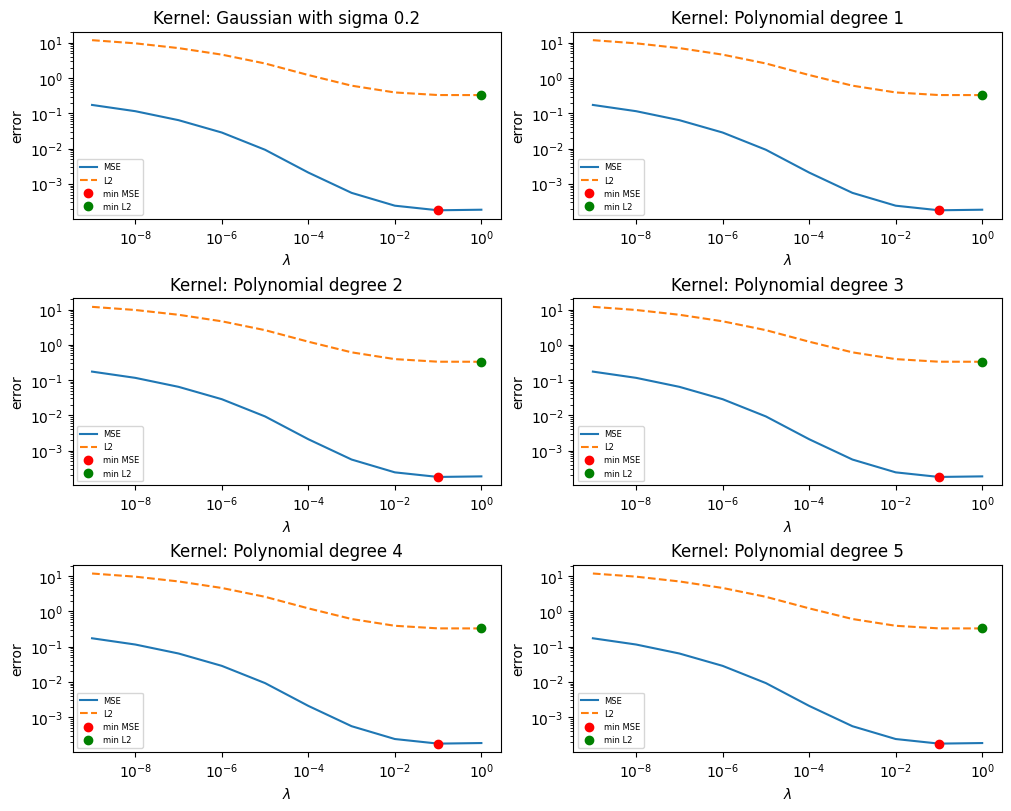

In [126]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, kernel in enumerate(operator_kernels):
    for amplitude_ref in amplitudes_list:
        ax[i].plot(lambda_opts, mean_error_mse[(amplitude_ref, kernel)], label=f'MSE')
        ax[i].plot(lambda_opts, mean_error_L2[(amplitude_ref, kernel)], label=f'L2', linestyle='--')
        argmin_mse = np.argmin(mean_error_mse[(amplitude_ref, kernel)])
        ax[i].plot(lambda_opts[argmin_mse], mean_error_mse[(amplitude_ref, kernel)][argmin_mse], marker = 'o', linestyle='', color='red', label='min MSE')
        argmin_L2 = np.argmin(mean_error_L2[(amplitude_ref, kernel)])
        ax[i].plot(lambda_opts[argmin_L2], mean_error_L2[(amplitude_ref, kernel)][argmin_L2], marker = 'o', linestyle='', color='green', label='min L2')
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(r'$\lambda$')
        ax[i].set_ylabel('error')
        ax[i].set_title(f'Kernel: {kernel}')
        ax[i].legend(loc=3, prop={'size': 6})
        

    

In [113]:
np.argmin(mean_error_mse[(amplitude_ref, kernel)])

8

In [114]:
lambda_opts[np.argmin(mean_error_mse[(amplitude_ref, kernel)])]

0.1

In [118]:
lambda_opts[8]

0.1

In [ ]:
plt.plot(lambda_opts[np.argmin(mean_error_mse[(amplitude_ref, kernel)])], mean)